<a href="https://colab.research.google.com/github/shahin1009/EDMD/blob/main/EDMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extended Dynamic Mode Decomposition (EDMD)
###(basically for finding koopman eignfuncions)

## Introduction:
This notebook presents an in-depth analysis of nonlinear dynamical systems, focusing on performing data-driven analysis. The notebook covers different stages of analysis, starting from the numerical integration of ordinary differential equations (ODEs) to the implementation of the Extended Dynamic Mode Decomposition (EDMD) method.

Suppose you have dynamic measurements of a system, **specifically y and dy**. First you need to build a dictinary of observables using the data

## Building the dictionary of observables



In [106]:
import numpy as np

def buildTheta(yin, nVars, polyorder):


    """
    Builds a polynomial dictionary from input data.

    Args:
        yin: Input data.
        nVars: Number of input variables.
        polyorder: Polynomial order.

    Returns:
        Polynomial dictionary.
    """

    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, nVars))

    # Copy input variables to output
    for i in np.arange(nVars):
        yout[:, ind] = yin[:, i]
        ind += 1

    if polyorder >= 2:
        # Polynomial order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = yin[:, i] * yin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
                ind += 1

    if polyorder >= 3:
        # Polynomial order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = yin[:, i] * yin[:, j] * yin[:, k]
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
                    ind += 1

    if polyorder >= 4:
        # Polynomial order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = yin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
                        ind += 1


    return yout


In [107]:
def buildGamma(yin, ydotin, nVars, polyorder):
    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, nVars))
    for i in np.arange(nVars):
        yout[:, ind] = ydotin[:, i]
        ind += 1

    if polyorder >= 2:
        # poly order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = ydotin[:, i] * yin[:, j] + yin[:, i] * ydotin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
                ind += 1

    if polyorder >= 3:
        # poly order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = (
                        ydotin[:, i] * yin[:, j] * yin[:, k]
                        + yin[:, i] * ydotin[:, j] * yin[:, k]
                        + yin[:, i] * yin[:, j] * ydotin[:, k]
                    )
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
                    ind += 1

    if polyorder >= 4:
        # poly order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = (
                            ydotin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                            + yin[:, i] * ydotin[:, j] * yin[:, k] * yin[:, l]
                            + yin[:, i] * yin[:, j] * ydotin[:, k] * yin[:, l]
                            + yin[:, i] * yin[:, j] * yin[:, k] * ydotin[:, l]
                        )
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
                        ind += 1

    return yout


## For printing purposes:

In [108]:
import numpy as np

def poolDataLIST(yin, ahat, nVars, polyorder):
    n = len(yin)+1
    ind = 0
    yout = []

    for i in range(nVars):
        yout.append([yin[i]])
        ind += 1

    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout.append([yin[i], yin[j]])
                ind += 1

    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout.append([yin[i], yin[j], yin[k]])
                    ind += 1

    if polyorder >= 4:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k, nVars):
                        yout.append([yin[i], yin[j], yin[k], yin[l]])
                        ind += 1

    if polyorder >= 5:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k, nVars):
                        for m in range(l, nVars):
                            yout.append([yin[i], yin[j], yin[k], yin[l], yin[m]])
                            ind += 1

    output = yout

    for item1, item2 in zip(output, ahat):
      print(f'{item1}\t{item2}'.replace(", ", "").replace("'", ""))
    return output


## Generating the data from a known dynamic

\begin{align*}
\dot{x} &= y \\
\dot{y} &= x - x^3 \\
\end{align*}

In [109]:
from scipy.integrate import odeint
from scipy.linalg import svd

def f(q, t):
    x, y = q
    return [y, x-x**3]

def solve(ic,t):
    sol = odeint(f, ic, t)
    return sol

t = np.linspace(0, 10, 10000)
x0 = np.array([0, -2.8])
y=solve(x0,t)
dy = np.array(f(y.T,t)).T

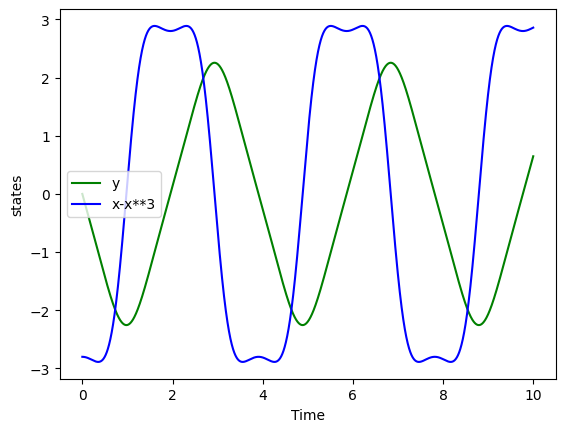

In [110]:
import matplotlib.pyplot as plt

# Plotting the data
plt.plot(t, y[:,0], color='green', label='y')
plt.plot(t, y[:,1], color='blue', label='x-x**3')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('states')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

## Extended Dynamic Mode Decomposition (EDMD) using Singular Value Decomposition (SVD):

1- Specify the desired polynomial order (polyorder) and number of variables (nvar) for the EDMD.

2- Build the library matrix Theta using the data y, number of variables, and polynomial order. The library matrix captures the polynomial basis functions of the data.

3- Build the library matrix Gamma using the data y and its derivative dy, along with the number of variables and polynomial order. The library matrix Gamma captures the polynomial basis functions of the time derivatives.

4- Perform Singular Value Decomposition (SVD) on the difference between a zero matrix and the library matrix Theta multiplied by a scalar Gamma. This step helps identify the dominant modes in the data.

5- Extract the last row of the right singular vectors matrix V (corresponding to the smallest singular value) and assign it to the sparse vector xi0. The sparse vector represents the coefficients of the dominant modes.

6- Set small values in xi0 to zero.

7- Generate the output using the sparse vector xi0 by calling poolDataLIST() with the appropriate arguments. This step constructs the output using the identified sparse coefficients.

In [111]:
# Construct libraries
polyorder = 4
nvar = 2

# Build the library matrix Theta
Theta = buildTheta(y, nvar, polyorder)

# Build the library matrix Gamma
Gamma = buildGamma(y, dy, nvar, polyorder)

# Perform SVD
U, S, V = svd(0 * Theta - Gamma, full_matrices=False)

# Extract the sparse vector xi0
xi0 = V[-1, :]
xi0[np.abs(xi0) < 1e-3] = 0

# Generate the output using the sparse vector
output = poolDataLIST(['x', 'y', 'z'], xi0, nvar, polyorder)


[x]	0.0
[y]	0.0
[xx]	-0.6666666666666667
[xy]	0.0
[yy]	0.6666666666666669
[xxx]	0.0
[xxy]	0.0
[xyy]	0.0
[yyy]	0.0
[xxxx]	0.33333333333333337
[xxxy]	0.0
[xxyy]	0.0
[xyyy]	0.0
[yyyy]	0.0


This is the Hamiltonian of the system!

$H = \frac{1}{2}y^2 - \frac{1}{2}x^2 + \frac{1}{4}x^4$


## least-squares Koopman algorithm breakdown:

1-Specify the desired polynomial order (polyorder) and number of variables (nvar).

2-Build the library matrix Theta using the data y and the specified number of variables and polynomial order.

3-Build the library matrix Gamma using the data y and its derivative dy, along with the specified number of variables and polynomial order.

4-Compute the Koopman operator K using the pseudo-inverse of Theta multiplied by Gamma. **This step is the core of the least-squares approach.**

5-Set small values in K to zero to enhance numerical stability.

6-Compute the eigenvalues (D) and eigenvectors (T) of K using np.linalg.eig().

7-Sort the eigenvalues (D) in ascending order and obtain the sorted indices (IX) using np.argsort().

8-Extract the eigenvector corresponding to the smallest eigenvalue from the eigenvector matrix T and assign it to xi1.


9-Generate the output using the absolute value of xi1 by calling poolDataLIST() to get the polynomial coefficients.

In [112]:
# Define the desired polynomial order and number of variables
polyorder = 4
nvar = 2

# Build the library matrix Theta from data (y)
Theta = buildTheta(y, nvar, polyorder)

# Build the library matrix Gamma from data (y and dy)
Gamma = buildGamma(y, dy, nvar, polyorder)

# Compute the Koopman operator using the least-squares approach
K = np.linalg.pinv(Theta) @ Gamma

# Set small values in K to zero for numerical stability
K[np.abs(K) < 1e-12] = 0

# Compute the eigenvalues (D) and eigenvectors (T) of K
D, T = np.linalg.eig(K)

# Sort the eigenvalues (D) in ascending order and obtain the sorted indices (IX)
IX = np.argsort(np.abs(D))

# Extract the eigenvector (xi1) corresponding to the smallest eigenvalue
xi1 = T[:, IX[0]]

# Set small values in xi1 to zero for numerical stability
xi1[np.abs(xi1) < 1e-12] = 0

# Generate the output using the absolute value of xi1
output = poolDataLIST(['x', 'y'], abs(xi1), nvar, polyorder)


[x]	0.0
[y]	0.0
[xx]	0.6666666666666792
[xy]	0.0
[yy]	0.6666666666666536
[xxx]	0.0
[xxy]	0.0
[xyy]	0.0
[yyy]	0.0
[xxxx]	0.33333333333333426
[xxxy]	0.0
[xxyy]	0.0
[xyyy]	0.0
[yyyy]	0.0


## SINDY: 

The sparse identification of nonlinear dynamics (SINDy) algorithm is a data-driven method for finding the governing equations of a dynamical system from sparse data. It basically performs a sparsity-promoting regression using least squares with some regularization to make it sparse. The algorithm assumes that the system has only a few dominant terms that dictate the dynamics, and constructs a library of nonlinear candidate functions to fit the data. 

### The original paper that introduced SINDy was published in 2016 by Brunton et al.

In [113]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

In [114]:
polyorder = 4
nvar = 2
Theta = buildTheta(y, nvar, polyorder)
lamb = 0.025 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dy,lamb,nvar)

output = poolDataLIST(['x', 'y', 'z'], Xi, nvar, polyorder)

[x]	[0. 1.]
[y]	[1. 0.]
[xx]	[0. 0.]
[xy]	[0. 0.]
[yy]	[0. 0.]
[xxx]	[ 0. -1.]
[xxy]	[0. 0.]
[xyy]	[0. 0.]
[yyy]	[0. 0.]
[xxxx]	[0. 0.]
[xxxy]	[0. 0.]
[xxyy]	[0. 0.]
[xyyy]	[0. 0.]
[yyyy]	[0. 0.]


first column is the dynamic coefficients of $\dot{x}$

second column is the dynamic coefficients of $\dot{y}$

## SINDY for Lorenz:



\begin{align*}
\dot{x} &= \sigma (y - x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= xy - \beta z \\
\end{align*}

In [115]:
# Lorenz Derivitive
def lorenz_deriv(x_y_z, t0, sigma=10, beta=8/3, rho=28):
    # Unpack the input variables
    x, y, z = x_y_z

    # Compute the derivatives
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    # Return the derivatives
    return [dx_dt, dy_dt, dz_dt]


def solve_lorenz(ic, t, sigma=10, beta=8/3, rho=28):
    # Solve the Lorenz system of equations using odeint
    sol = odeint(lorenz_deriv, ic, t, args=(sigma, beta, rho))
    return sol

# Define the time steps for integration
t = np.linspace(0, 100, 100000)

# Set the initial conditions
x0 = [0, 1, 0]

# Solve the Lorenz system
y = solve_lorenz(x0, t)

# Compute the derivative of the solution
dy = np.array(lorenz_deriv(y.T, t)).T

SINDY:

In [116]:
polyorder = 3
nvar = 3
lamb = 0.025 # sparsification knob lambda
Theta = buildTheta(y, nvar, polyorder)
Xi = sparsifyDynamics(Theta,dy,lamb,nvar)

output = poolDataLIST(['x', 'y', 'z'], Xi, nvar, polyorder)

[x]	[-10.  28.   0.]
[y]	[10. -1.  0.]
[z]	[ 0.          0.         -2.66666667]
[xx]	[0. 0. 0.]
[xy]	[0. 0. 1.]
[xz]	[ 0. -1.  0.]
[yy]	[0. 0. 0.]
[yz]	[0. 0. 0.]
[zz]	[0. 0. 0.]
[xxx]	[0. 0. 0.]
[xxy]	[0. 0. 0.]
[xxz]	[0. 0. 0.]
[xyy]	[0. 0. 0.]
[xyz]	[0. 0. 0.]
[xzz]	[0. 0. 0.]
[yyy]	[0. 0. 0.]
[yyz]	[0. 0. 0.]
[yzz]	[0. 0. 0.]
[zzz]	[0. 0. 0.]


first column is the dynamic coefficients of $\dot{x}$

second column is the dynamic coefficients of $\dot{y}$

third column is the dynamic coefficients of $\dot{z}$

In [117]:
# Construct libraries
polyorder = 3
nvar = 3

# Build the library matrix Theta
Theta = buildTheta(y, nvar, polyorder)

# Build the library matrix Gamma
Gamma = buildGamma(y, dy, nvar, polyorder)

# Perform SVD
U, S, V = svd(0 * Theta - Gamma, full_matrices=False)

# Extract the sparse vector xi0
xi0 = V[-1, :]
xi0[np.abs(xi0) < 0.005] = 0

# Generate the output using the sparse vector
output = poolDataLIST(['x', 'y', 'z'], xi0, nvar, polyorder)

[x]	0.8847513519784561
[y]	-0.46259824963530666
[z]	0.0
[xx]	0.0
[xy]	0.0
[xz]	-0.05109122509834033
[yy]	0.0
[yz]	0.023772354342215706
[zz]	0.0
[xxx]	0.0
[xxy]	0.0
[xxz]	0.0
[xyy]	0.0
[xyz]	0.0
[xzz]	0.0
[yyy]	0.0
[yyz]	0.0
[yzz]	0.0
[zzz]	0.0
